In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!nvidia-smi

Wed May  8 19:50:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# unzipping the data
!unzip /content/drive/MyDrive/Eye.zip -d /content/Eye

Archive:  /content/drive/MyDrive/Eye.zip
replace /content/Eye/Eye/Proliferate_DR/7b211d8bd249_png_jpg.rf.da94c1a9c145de0452ec5dcc0308be9d.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
import pathlib
# Path to the dataset in your Google Drive
data_dir = 'Eye/Eye'

# If you need to extract a compressed file, you can do it like this:
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = pathlib.Path(data_dir).with_suffix('')
# data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)

# Now data_dir points to your dataset folder in Google Drive

In [6]:
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


2838


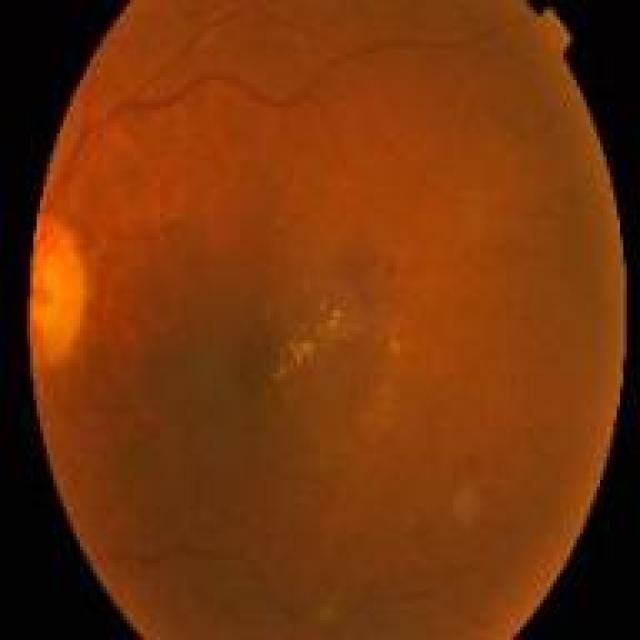

In [7]:
Mild = list(data_dir.glob('Mild/*'))
PIL.Image.open(str(Mild[0]))


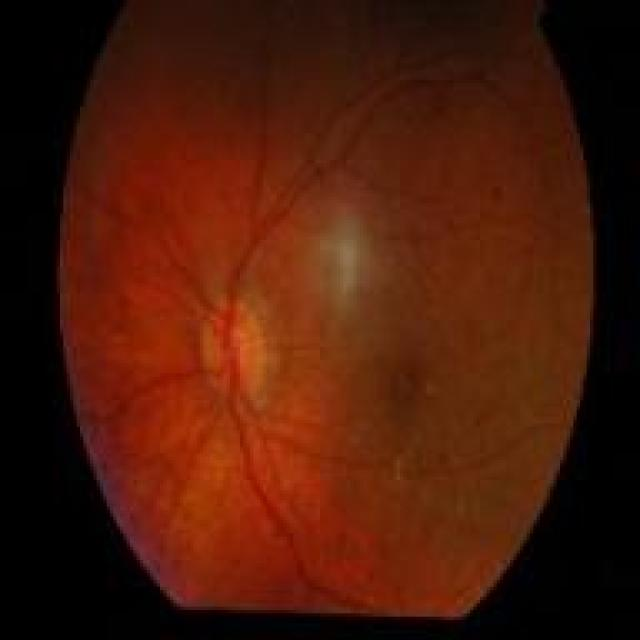

In [8]:
Moderate = list(data_dir.glob('Moderate/*'))
PIL.Image.open(str(Moderate[0]))

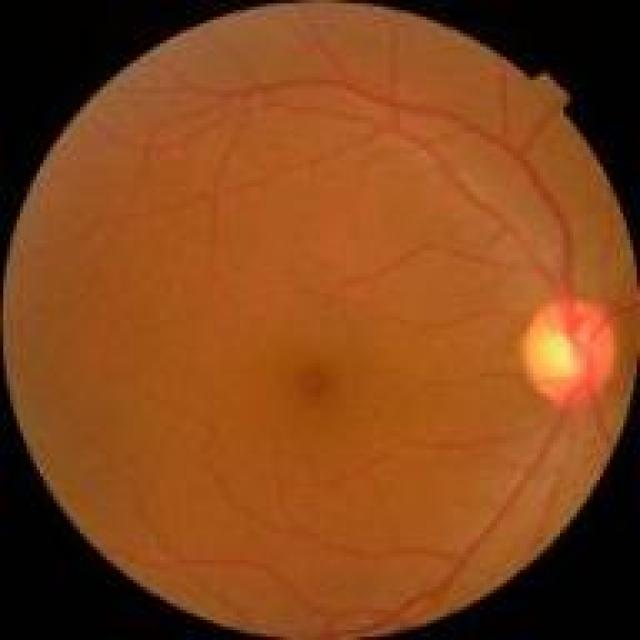

In [9]:
No_DR = list(data_dir.glob('No_DR/*'))
PIL.Image.open(str(No_DR[0]))

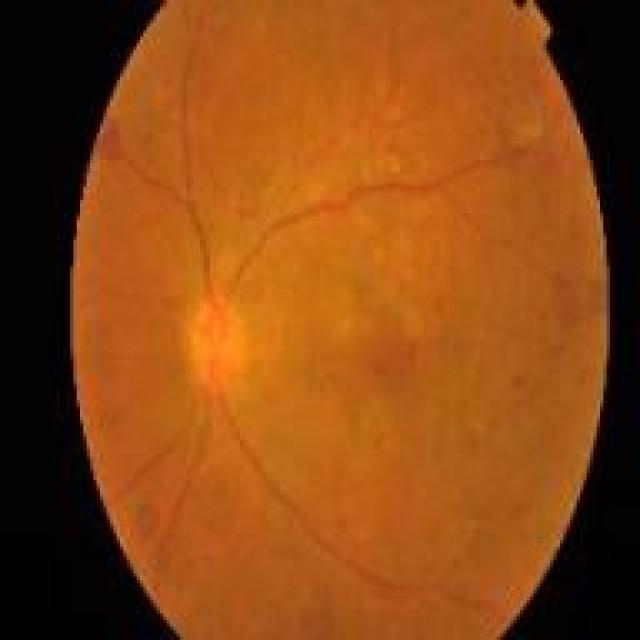

In [10]:
Proliferate_DR = list(data_dir.glob('Proliferate_DR/*'))
PIL.Image.open(str(Proliferate_DR[0]))

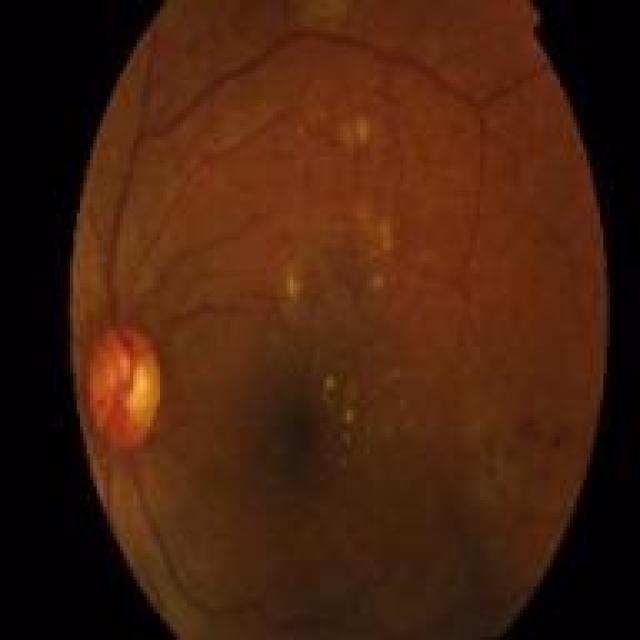

In [11]:
Severe = list(data_dir.glob('Severe/*'))
PIL.Image.open(str(Severe[0]))

In [12]:
batch_size = 16
img_height = 224
img_width = 224

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=2,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2838 files belonging to 5 classes.
Using 2271 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=2,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2838 files belonging to 5 classes.
Using 567 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


**First Nine Images from training dataset**

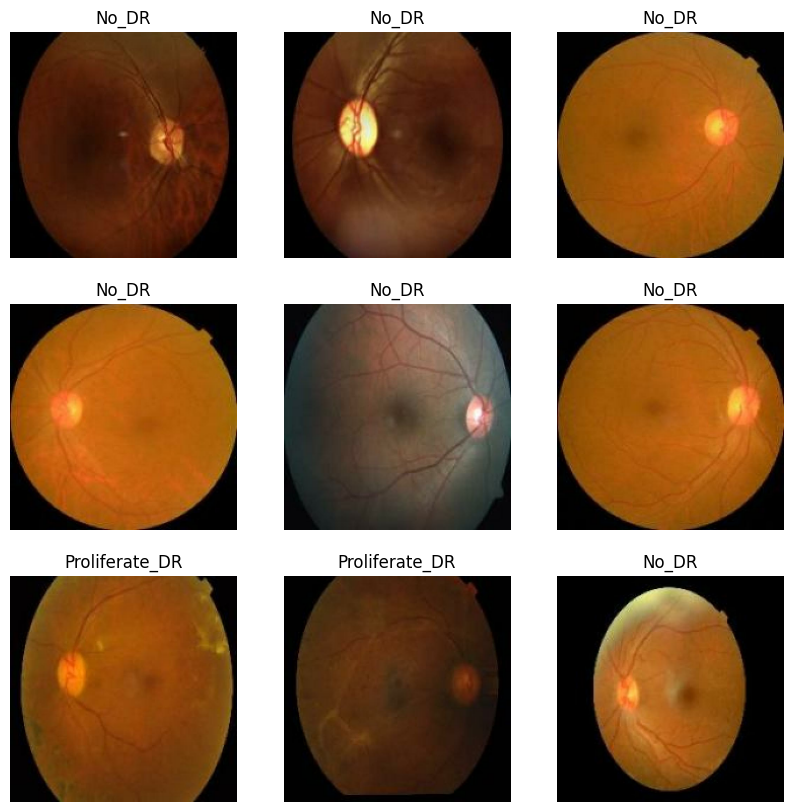

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [20]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                       input_shape=(img_height,
                                    img_width,
                                    3)),
    layers.RandomRotation(0.1, seed=2),
    layers.RandomZoom(0.1, seed=2),
    layers.RandomFlip(seed=2),
    layers.RandomBrightness(0.2, seed=2),
    layers.RandomContrast(0.3, seed=2),
])

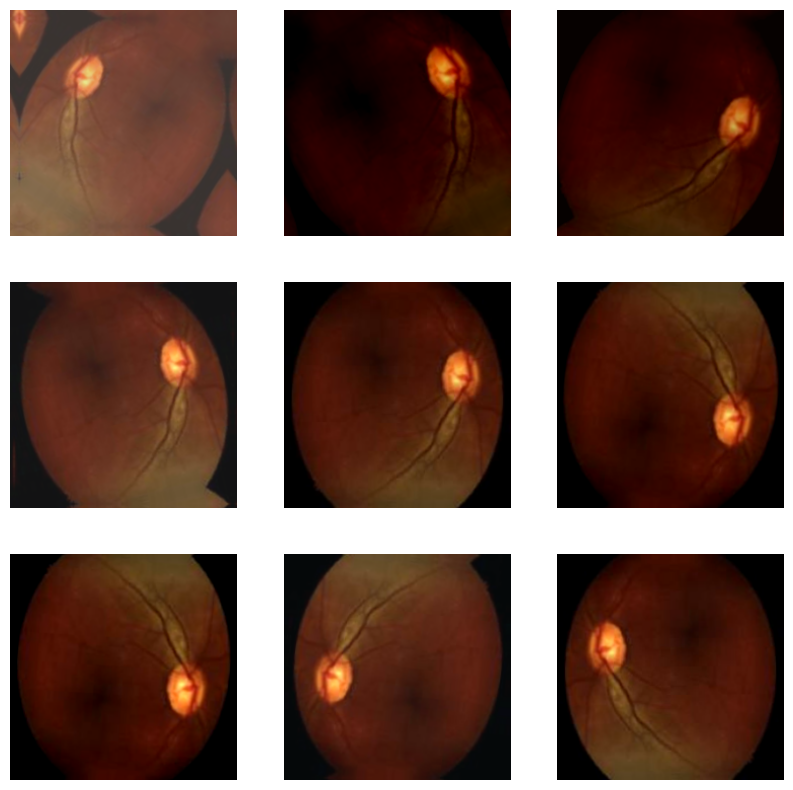

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
num_classes = len(class_names)
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                 

In [25]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


142/142 [==============================] - 13s 53ms/step - loss: 1.1092 - accuracy: 0.5936 - val_loss: 0.9793 - val_accuracy: 0.6808
Epoch 2/20
142/142 [==============================] - 5s 34ms/step - loss: 0.9429 - accuracy: 0.6675 - val_loss: 0.8493 - val_accuracy: 0.6667
Epoch 3/20
142/142 [==============================] - 5s 34ms/step - loss: 0.9061 - accuracy: 0.6733 - val_loss: 0.8341 - val_accuracy: 0.6843
Epoch 4/20
142/142 [==============================] - 5s 34ms/step - loss: 0.8522 - accuracy: 0.6988 - val_loss: 0.7773 - val_accuracy: 0.7002
Epoch 5/20
142/142 [==============================] - 5s 33ms/step - loss: 0.8537 - accuracy: 0.6935 - val_loss: 0.7513 - val_accuracy: 0.6984
Epoch 6/20
142/142 [==============================] - 4s 31ms/step - loss: 0.8183 - accuracy: 0.7050 - val_loss: 0.7651 - val_accuracy: 0.7266
Epoch 7/20
142/142 [==============================] - 5s 32ms/step - loss: 0.8207 - accuracy: 0.7067 - val_loss: 0.7605 - val_accuracy: 0.7072
Epoch 8/2

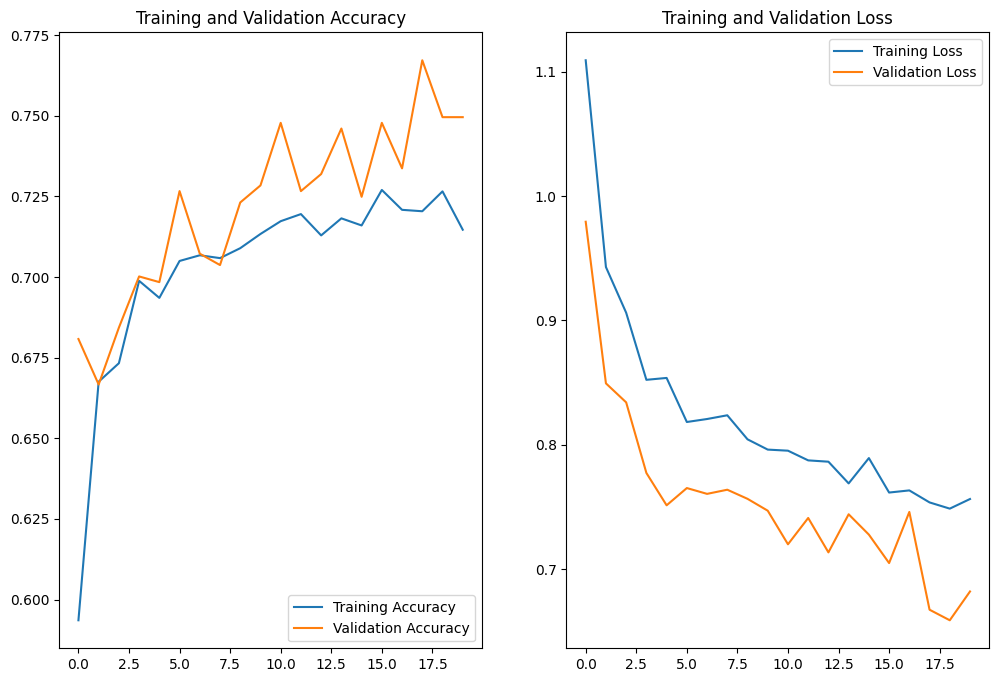

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Transfer learning

In [27]:
from tensorflow.keras import layers, models

In [28]:
from tensorflow.keras.applications import MobileNetV3Large

base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 960)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               123008    
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 3120005 (11.90 MB)
Trainable params: 123

In [29]:
epochs=21
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/21
142/142 [==============================] - 12s 44ms/step - loss: 0.9691 - accuracy: 0.6720 - val_loss: 0.6647 - val_accuracy: 0.7831
Epoch 2/21
142/142 [==============================] - 4s 27ms/step - loss: 0.7314 - accuracy: 0.7345 - val_loss: 0.6194 - val_accuracy: 0.7937
Epoch 3/21
142/142 [==============================] - 3s 24ms/step - loss: 0.6690 - accuracy: 0.7464 - val_loss: 0.5954 - val_accuracy: 0.7654
Epoch 4/21
142/142 [==============================] - 3s 24ms/step - loss: 0.6281 - accuracy: 0.7688 - val_loss: 0.5730 - val_accuracy: 0.7866
Epoch 5/21
142/142 [==============================] - 4s 27ms/step - loss: 0.6190 - accuracy: 0.7710 - val_loss: 0.5458 - val_accuracy: 0.7937
Epoch 6/21
142/142 [==============================] - 3s 24ms/step - loss: 0.5793 - accuracy: 0.7851 - val_loss: 0.5671 - val_accuracy: 0.7743
Epoch 7/21
142/142 [==============================] - 4s 25ms/step - loss: 0.5698 - accuracy: 0.7882 - val_loss: 0.5437 - val_accuracy: 0.798

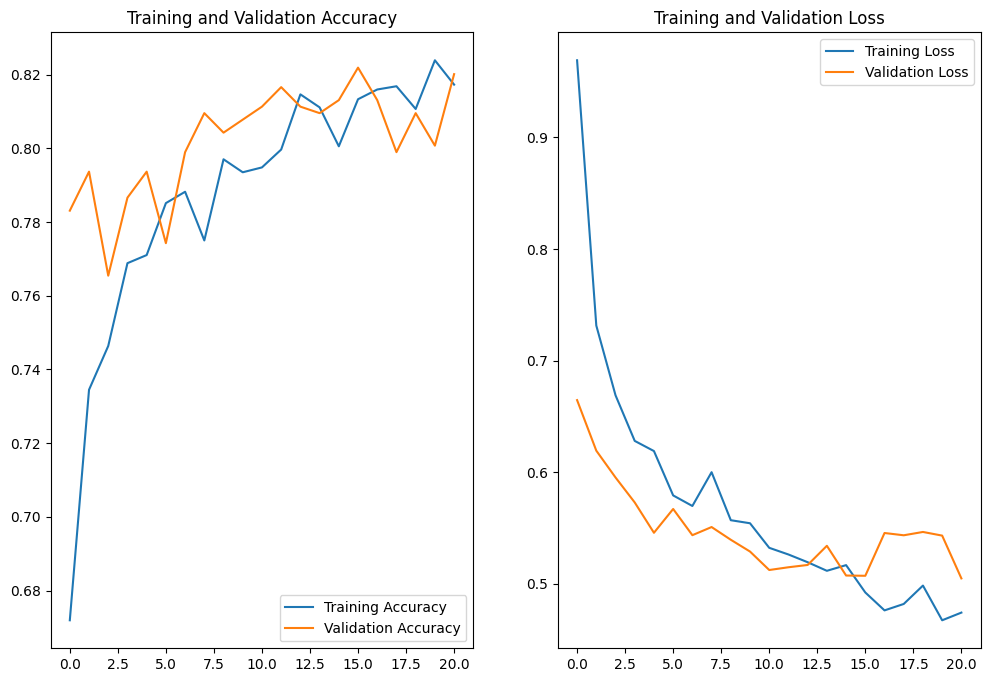

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

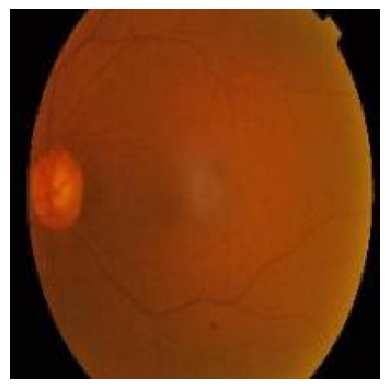

1/1 [==============================] - 2s 2s/step
This image most likely belongs to Mild with a 36.33 percent confidence.


In [31]:
# Path to the image in your Google Drive
eye_path = 'Eye/Eye/Mild/0024cdab0c1e_png_jpg.rf.be534a3f321f6a4dcbe72e0e7616f99c.jpg'

# Load the image
img = tf.keras.preprocessing.image.load_img(eye_path, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0) # Create a batch

# Print the image
plt.imshow(img)
plt.axis('off')  # Remove axes
plt.show()

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Output the prediction result
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']  # Define your class names
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

In [32]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)